Tuning combination 1/54 -> particles=10, w=0.5, c1=1.0, c2=1.0
Stress Score: 4.3527
Tuning combination 2/54 -> particles=10, w=0.5, c1=1.0, c2=1.5
Stress Score: 4.9178
Tuning combination 3/54 -> particles=10, w=0.5, c1=1.0, c2=2.0
Stress Score: 4.4072
Tuning combination 4/54 -> particles=10, w=0.5, c1=1.5, c2=1.0
Stress Score: 4.6697
Tuning combination 5/54 -> particles=10, w=0.5, c1=1.5, c2=1.5
Stress Score: 4.8445
Tuning combination 6/54 -> particles=10, w=0.5, c1=1.5, c2=2.0
Stress Score: 5.4206
Tuning combination 7/54 -> particles=10, w=0.5, c1=2.0, c2=1.0
Stress Score: 3.1817
Tuning combination 8/54 -> particles=10, w=0.5, c1=2.0, c2=1.5
Stress Score: 4.3696
Tuning combination 9/54 -> particles=10, w=0.5, c1=2.0, c2=2.0
Stress Score: 8.6295
Tuning combination 10/54 -> particles=10, w=0.7, c1=1.0, c2=1.0
Stress Score: 3.9002
Tuning combination 11/54 -> particles=10, w=0.7, c1=1.0, c2=1.5
Stress Score: 4.1680
Tuning combination 12/54 -> particles=10, w=0.7, c1=1.0, c2=2.0
Stress Sco

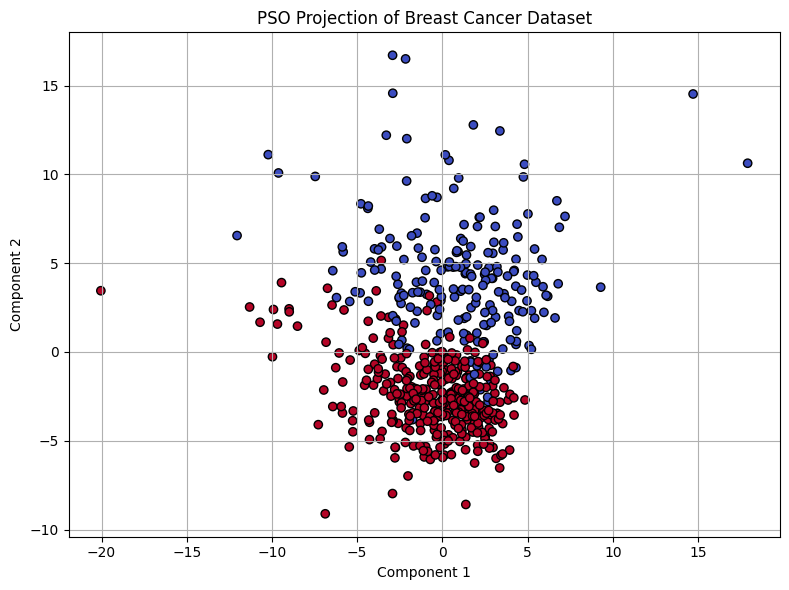

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import product

np.random.seed(42)  # for reproducibility

class PSO:
    def __init__(self, output_dim=2, n_particles=10, w=0.7, c1=1.5, c2=1.5):
        self.output_dim = output_dim
        self.n_particles = n_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = None
        self.velocities = None
        self.pbest = None
        self.pbest_scores = None
        self.gbest = None
        self.gbest_score = float('inf')
        self.projected_data = None

    def stress(self, X, W):
        try:
            Y = X @ W
            orig_dist = np.linalg.norm(X[:, None] - X, axis=2)
            proj_dist = np.linalg.norm(Y[:, None] - Y, axis=2)
            return np.mean((orig_dist - proj_dist) ** 2)
        except Exception as e:
            print(f"⚠️ Error in stress calculation: {e}")
            return float('inf')

    def initialize(self, data):
        input_dim = data.shape[1]
        self.particles = [np.random.randn(input_dim, self.output_dim) for _ in range(self.n_particles)]
        self.velocities = [np.zeros((input_dim, self.output_dim)) for _ in range(self.n_particles)]
        self.pbest = [p.copy() for p in self.particles]
        self.pbest_scores = [self.stress(data, p) for p in self.particles]
        best_idx = np.argmin(self.pbest_scores)
        self.gbest = self.pbest[best_idx].copy()
        self.gbest_score = self.pbest_scores[best_idx]

    def train(self, data, epochs):
        input_dim = data.shape[1]
        self.initialize(data)
        for epoch in range(epochs):
            for i in range(self.n_particles):
                current_score = self.stress(data, self.particles[i])
                if current_score < self.pbest_scores[i]:
                    self.pbest[i] = self.particles[i].copy()
                    self.pbest_scores[i] = current_score
                if current_score < self.gbest_score:
                    self.gbest = self.particles[i].copy()
                    self.gbest_score = current_score
            for i in range(self.n_particles):
                r1 = np.random.rand(input_dim, self.output_dim)
                r2 = np.random.rand(input_dim, self.output_dim)
                cognitive = self.c1 * r1 * (self.pbest[i] - self.particles[i])
                social = self.c2 * r2 * (self.gbest - self.particles[i])
                self.velocities[i] = self.w * self.velocities[i] + cognitive + social
                self.particles[i] += self.velocities[i]
        self.projected_data = data @ self.gbest

    def stress_score(self, data):
        return self.stress(data, self.gbest)

    @staticmethod
    def tune_parameters(data, epochs=100, verbose=True):
        best_score = float('inf')
        best_model = None
        best_params = {}

        output_dims = [2]
        particles = [10, 20]
        inertias = [0.5, 0.7, 0.9]
        c1_values = [1.0, 1.5, 2.0]
        c2_values = [1.0, 1.5, 2.0]

        total_combinations = len(output_dims) * len(particles) * len(inertias) * len(c1_values) * len(c2_values)
        combo_idx = 1

        for od, npart, w, c1, c2 in product(output_dims, particles, inertias, c1_values, c2_values):
            if verbose:
                print(f"Tuning combination {combo_idx}/{total_combinations} -> particles={npart}, w={w}, c1={c1}, c2={c2}")
            combo_idx += 1

            pso = PSO(output_dim=od, n_particles=npart, w=w, c1=c1, c2=c2)
            pso.train(data, epochs)
            score = pso.stress_score(data)

            if verbose:
                print(f"Stress Score: {score:.4f}")

            if score < best_score:
                best_score = score
                best_model = pso
                best_params = {
                    'output_dim': od,
                    'n_particles': npart,
                    'w': w,
                    'c1': c1,
                    'c2': c2
                }

        return best_model, best_params, best_score

# Load and preprocess breast cancer data
data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)

# Run tuning
best_model, best_params, best_stress = PSO.tune_parameters(X, epochs=100)

# Show results
print("\nBest Parameters Found:")
print(best_params)
print(f"Best Stress Score: {best_stress:.4f}")

# Visualize
y = data.target
projected = best_model.projected_data

plt.figure(figsize=(8, 6))
plt.scatter(projected[:, 0], projected[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("PSO Projection of Breast Cancer Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()